Relaxed entropy dual, where we estimate $\varphi$ only, replacing $\psi$ with first order optimality condition.

In [1]:
import torch
from torch import nn
from torch import Tensor

class PosLinear(torch.nn.Linear):
    def forward(self, x: Tensor) -> Tensor:
        gain = 1
        return nn.functional.linear(x, torch.nn.functional.softplus(self.weight), self.bias) * gain

class PICNN(nn.Module):
    def __init__(self,
            x_dimension: int,
            y_dimension: int,
            u_dimension: int,
            z_dimension: int,
            output_dimension: int,
            number_of_hidden_layers: int
        ):
        super(PICNN, self).__init__()


        # Activations:
        self.z_activation = nn.Softplus()
        self.u_activation = nn.Softplus()
        self.positive_activation = nn.Softplus()

        # First layer
        self.first_linear_layer_tilde = nn.Linear(x_dimension, u_dimension)
        self.first_linear_layer_yu = nn.Linear(x_dimension, y_dimension)
        self.first_linear_layer_y = nn.Linear(y_dimension, z_dimension, bias=False)
        self.first_linear_layer_u = nn.Linear(x_dimension, z_dimension, bias=False)

        # Iterations:
        self.linear_layer_tilde = nn.ModuleList([
                nn.Linear(u_dimension, u_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_uz = nn.ModuleList([
            nn.Linear(u_dimension, z_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_z = nn.ModuleList([
            nn.Linear(z_dimension, z_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_uy = nn.ModuleList([
            nn.Linear(u_dimension, y_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_y = nn.ModuleList([
            nn.Linear(y_dimension, z_dimension, bias=False)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_u = nn.ModuleList([
            nn.Linear(u_dimension, z_dimension, bias=False)
                for _ in range(number_of_hidden_layers)
        ])
        self.number_of_hidden_layers = number_of_hidden_layers

        # Last layer:
        self.last_linear_layer_uz = nn.Linear(u_dimension, z_dimension)
        self.last_linear_layer_z = nn.Linear(z_dimension, output_dimension)
        self.last_linear_layer_uy = nn.Linear(u_dimension, y_dimension)
        self.last_linear_layer_y = nn.Linear(y_dimension, output_dimension, bias=False)
        self.last_linear_layer_u = nn.Linear(u_dimension, output_dimension, bias=False)


    def forward(self, x, y):
        # First layer:
        u = self.u_activation(
            self.first_linear_layer_tilde(x)
        )
        z = self.z_activation(
            self.first_linear_layer_y(
                y * self.first_linear_layer_yu(x)
            ) +
            self.first_linear_layer_u(x)
        )

        # Iterations:
        for iteration_number in range(self.number_of_hidden_layers):
            u, z = (
                self.u_activation(
                    self.linear_layer_tilde[iteration_number](u)
                ),
                self.z_activation(
                    self.linear_layer_z[iteration_number](
                        z * self.positive_activation((self.linear_layer_uz[iteration_number](u)))
                    ) + \
                    self.linear_layer_y[iteration_number](
                        y * self.linear_layer_uy[iteration_number](u)
                    ) + \
                    self.linear_layer_u[iteration_number](u)
                )
            )

        # Last layer:
        output = self.last_linear_layer_z(
            z * self.positive_activation(self.last_linear_layer_uz(u))
        ) + \
        self.last_linear_layer_y(
            y * self.last_linear_layer_uy(u)
        ) + \
        self.last_linear_layer_u(u)

        return output

def torch_sphere_uniform(n, d, **kwargs):
    """Generate n points inside the d-dimensional sphere."""
    random_vectors = torch.randn(n, d, **kwargs)
    vectors_norms = torch.norm(random_vectors, dim=1, keepdim=True)
    radius = torch.pow(torch.rand(n, 1, **kwargs), 1. / d)
    return radius * random_vectors / vectors_norms

In [2]:
from data_utils import create_joint_x_y
import numpy as np

num_points_to_generate = 1000
X, Y = create_joint_x_y(num_points_to_generate)

n, d = Y.shape
m = n

phi_network = PICNN(
    x_dimension=X.shape[1],
    y_dimension=Y.shape[1],
    u_dimension=10,
    z_dimension=10,
    output_dimension=1,
    number_of_hidden_layers=2,
)

In [3]:
import torch
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
num_epochs = 5000

phi_network.to(**device_and_dtype_specifications)
phi_network_optimizer = torch.optim.Adam([dict(params=phi_network.parameters())], lr=0.01)

X, Y = create_joint_x_y(num_points_to_generate)
X_tensor = torch.tensor(X, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
dataset_size = num_points_to_generate
batch_size = 256

def estimate_U_tensor(X_tensor, Y_tensor, phi_net, max_number_of_iterations=50):
        U_tensor = torch_sphere_uniform(Y_tensor.shape[0], Y_tensor.shape[1], **device_and_dtype_specifications)
        U_tensor.requires_grad = True
        U_tensor_optimizer = torch.optim.Adam([U_tensor], lr=0.01)

        for _ in range(max_number_of_iterations):
                U_tensor_optimizer.zero_grad()
                objective = (phi_net(X_tensor, U_tensor) - (U_tensor*Y_tensor).sum(dim=1, keepdims=True)).sum()
                objective.backward()
                U_tensor_optimizer.step()

                with torch.no_grad():
                        inverse_norm = 1 / torch.norm(U_tensor, dim=1, keepdim=True)
                        inverse_norm = inverse_norm * (inverse_norm < 1).float() + (inverse_norm >= 1).float()
                        U_tensor = U_tensor * inverse_norm

        return U_tensor

for epoch_idx in range(1, num_epochs):

        yindexes = torch.randint(0, dataset_size, (batch_size,))
        X_batch = X_tensor[yindexes]
        Y_batch = Y_tensor[yindexes]
        U_batch = torch_sphere_uniform(
                batch_size, Y_batch.shape[1],
                **device_and_dtype_specifications
        )

        tilde_U_batch = estimate_U_tensor(
                X_tensor=X_batch,
                Y_tensor=Y_batch,
                phi_net=phi_network
        )

        phi_network.zero_grad()
        phi = phi_network(X_batch, U_batch)
        psi = (tilde_U_batch*Y_batch).sum(dim=1, keepdims=True) - phi_network(X_batch, tilde_U_batch)

        objective = torch.mean(psi) + torch.mean(phi)
        objective.backward()
        phi_network_optimizer.step()
        print(objective.item(), epoch_idx)

_ = phi_network.eval()

-0.31998947901768704 1
0.000648863872977079 2
0.05633497435182758 3
-0.40288102007520293 4
-0.11326432486719515 5
0.11541465553025404 6
0.013171226315835477 7
0.023102319069579685 8
-0.25546196022278655 9
-0.3507338426922662 10
-0.1048374158853807 11
-0.28938275383713147 12
0.059914306848469934 13
0.034840968672341044 14
0.5876294420252013 15
-0.3092159374052803 16
0.24723579437397675 17
0.13222212854443954 18
-0.020021630060021833 19
0.11633696560680717 20
0.2066126147057688 21
0.8619530715760824 22
-0.13800968647013603 23
0.10986850410161869 24
-0.12134966349520154 25
0.011893399528048021 26
0.0310841643856562 27
0.08659205392584618 28
-0.2795467942342952 29
-0.0897220943379774 30
-0.10780551468896793 31
-0.07338214445746488 32
0.2036822001587657 33
0.22864414767420327 34
0.39037053426645707 35
-0.005558954484879863 36
0.08493671557968985 37
0.3091351784025085 38
0.0194079023407685 39
0.11228242696361346 40
0.1885008429641422 41
-0.013028992121744243 42
-0.08742343719320322 43
0.1973

In [4]:
# Change to %matplotlib qt to have interactive plots
%matplotlib qt
import matplotlib.pyplot as plt
from data_utils import create_conditional_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100])[:, None]

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_/100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):

    x = torch.tensor([x_ / 100], **device_and_dtype_specifications)[:, None]
    x = x.repeat(repeats=(20, 1))
    _, y_x_gt = create_conditional_x(n_points=20, x_value=x_/100)
    y = torch.tensor(y_x_gt, **device_and_dtype_specifications)

    colors = ['red', 'purple', 'green', 'orange', 'blue', 'pink']
    radii = [0.1, 0.5, 1., 1.5, 2, 3]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 20)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True
        potential = phi_network(x, u_tensor)
        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        z_line = x.detach().cpu().numpy()
        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

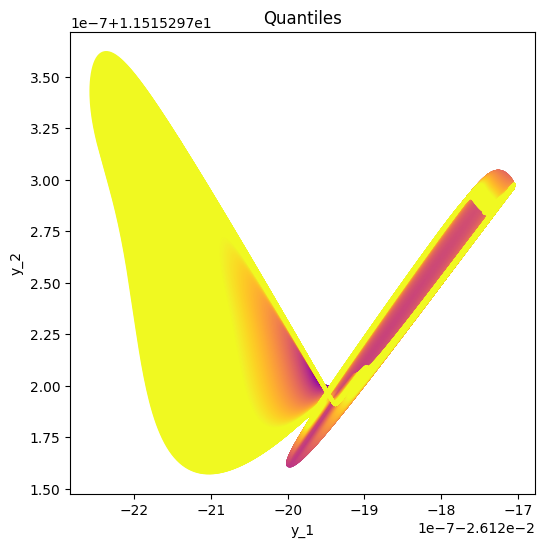

In [5]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.set_title('Quantiles')
ax1.set_xlabel('y_1')
ax1.set_ylabel('y_2')
x = torch.tensor([2.5], **device_and_dtype_specifications)[:, None]

radii = np.linspace(0.01, 4, 1000)
colors = matplotlib.colormaps['plasma'](radii/3)

for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 1000)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True

        potential = phi_network(x.repeat(u_tensor.shape[0], 1), u_tensor)

        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], color=color, linewidth=2.5)
